# 1: Replicate the baseline AI methodology using the open dataset 

## Install Requirements & Load Packages

In [ ]:
#!pip install -r requirements_working_2.txt

In [1]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import PIL
import pathlib
import os

# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import *
# from tensorflow.keras.losses import BinaryCrossentropy
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras import backend as K

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras import backend as K
from keras.callbacks import ModelCheckpoint

import requests
!pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
import sys

!pip install pyunpack patool rarfile segmentation-models rioxarray
from rarfile import RarFile
from keras.applications import vgg16
from sklearn.metrics import *
import rioxarray as rxr
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Document the used dependenies
# !pip freeze > requirements_working_2.txt

## Download & Preprocess Datasets

In [4]:
# Specify whether to download data or read in
download = False
base_dir = r"./Amazon Forest Dataset/"

### RGB

In [7]:
# Download data

# Path to patool executable inside your conda env
patool_path = r"C:\Users\Gebruiker\AppData\Local\r-miniconda\envs\deforestation\Scripts\patool.exe"

if download:
    url = 'https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    with open('data.rar', 'wb') as f:
        f.write(r.content)

# Use explicit patool_path
pyunpack.Archive('data.rar').extractall('', patool_path=patool_path)

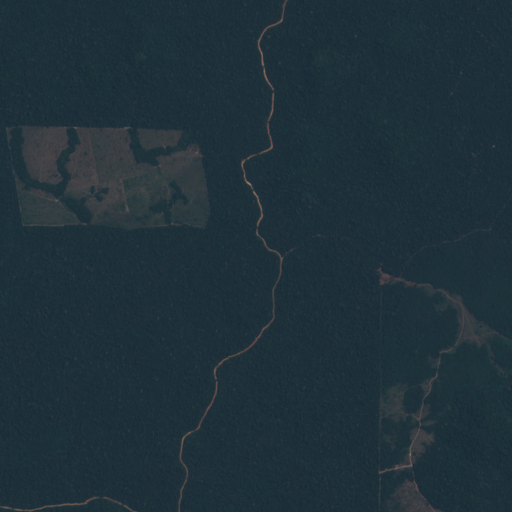

In [8]:
# Show example image from training data
PIL.Image.open(r"{}Training/images/Amazon_1110.tiff_25.tiff".format(base_dir))

In [ ]:
# %run preprocessing/preprocess-rgb-data.py

### 4-band Amazon

In [ ]:
download = False # True, if files don't already exist in same directory
base_dir2 = r"./AMAZON/"

In [12]:
# Download data Amazon

# Path to patool executable inside your conda env
patool_path = r"C:\Users\Gebruiker\AppData\Local\r-miniconda\envs\deforestation\Scripts\patool.exe"

if download:
    url = 'https://zenodo.org/record/4498086/files/AMAZON.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    with open('data2.rar', 'wb') as f:
        f.write(r.content)

# Use explicit patool_path
pyunpack.Archive('data2.rar').extractall('', patool_path=patool_path)

In [ ]:
# %run preprocessing/preprocess-4band-amazon-data.py

### 4-band Atlantic Forest

In [ ]:
download = False # True if files don't already exist in same directory
base_dir3 = r"./ATLANTIC FOREST/"

In [17]:
# Download data (Atlantic Forest)

# Path to patool executable inside your conda env
patool_path = r"C:\Users\Gebruiker\AppData\Local\r-miniconda\envs\deforestation\Scripts\patool.exe"

if download:
    url = 'https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    with open('data3.rar', 'wb') as f:
        f.write(r.content)

# Use explicit patool_path
pyunpack.Archive('data3.rar').extractall('', patool_path=patool_path)

In [ ]:
# %run preprocessing/preprocess-4band-atlantic-forest-data.py

## Adjustments to make training-ready and match way-of-working from paper

In [5]:
import glob
def load_npy_list(directory):
    files = sorted(glob.glob(os.path.join(directory, "*.npy")))
    arrays = [np.load(f) for f in files]
    return arrays, files

### RGB

In [6]:
BASE_DIR = r"amazon-processed-regular"

train_img_dir = os.path.join(BASE_DIR, "training", "images")
train_msk_dir = os.path.join(BASE_DIR, "training", "masks")
val_img_dir   = os.path.join(BASE_DIR, "validation", "images")
val_msk_dir   = os.path.join(BASE_DIR, "validation", "masks")

training_images, training_image_files   = load_npy_list(train_img_dir)
training_masks,  training_mask_files    = load_npy_list(train_msk_dir)
validation_images, validation_img_files = load_npy_list(val_img_dir)
validation_masks,  validation_msk_files = load_npy_list(val_msk_dir)

print(len(training_images), len(validation_images))
print("Example shape:", training_images[0].shape)

30 15
Example shape: (1, 512, 512, 3)


In [7]:
# Add some training images to validation data to increase size of validation set
for i in range(25,30):
  validation_images.append(training_images[i].reshape(1,512,512,3))
  validation_masks.append(training_masks[i].reshape(1,512,512,1))

# Remove five images from training data, which has been added to validation data
training_images = training_images[0:25]
training_masks = training_masks[0:25]

print("Train size:", len(training_images))
print("Val size:", len(validation_images))

Train size: 25
Val size: 20


In [8]:
# Create TensorFlow datasets for validation sets
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

### 4-band Amazon

In [9]:
BASE_DIR = r"amazon-processed-large" 

train_img_dir2 = os.path.join(BASE_DIR, "training", "images")
train_msk_dir2 = os.path.join(BASE_DIR, "training", "masks")
val_img_dir2   = os.path.join(BASE_DIR, "validation", "images")
val_msk_dir2   = os.path.join(BASE_DIR, "validation", "masks")

training_images2, training_image_files2   = load_npy_list(train_img_dir2)
training_masks2,  training_mask_files2    = load_npy_list(train_msk_dir2)
validation_images2, validation_img_files2 = load_npy_list(val_img_dir2)
validation_masks2,  validation_msk_files2 = load_npy_list(val_msk_dir2)

print(len(training_images2), len(validation_images2))
print("Example shape:", training_images2[0].shape)

250 100
Example shape: (1, 512, 512, 4)


In [10]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_amazon = tf.data.Dataset.from_tensor_slices((training_images2[0:250], training_masks2[0:250]))
validation_df_4band_amazon = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

### 4-band atlantic

In [11]:
BASE_DIR = r"atlantic-processed-large" 

train_img_dir3 = os.path.join(BASE_DIR, "training", "images")
train_msk_dir3 = os.path.join(BASE_DIR, "training", "masks")
val_img_dir3   = os.path.join(BASE_DIR, "validation", "images")
val_msk_dir3   = os.path.join(BASE_DIR, "validation", "masks")

training_images3, training_image_files3   = load_npy_list(train_img_dir3)
training_masks3,  training_mask_files3    = load_npy_list(train_msk_dir3)
validation_images3, validation_img_files3 = load_npy_list(val_img_dir3)
validation_masks3,  validation_msk_files3 = load_npy_list(val_msk_dir3)

print(len(training_images3), len(validation_images3))
print("Example shape:", training_images3[0].shape)

250 100
Example shape: (1, 512, 512, 4)


In [12]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((training_images3[0:250], training_masks3[0:250]))
validation_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((validation_images3, validation_masks3))

## Functions

In [13]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [14]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

In [15]:
#
# Data loader/generator from: https://github.com/bragagnololu/UNet-defmapping.git
#

def adjustData(img, mask, num_class):
  
    mask[mask > 0.5] = 1 # FOREST
    mask[mask <= 0.5] = 0 # NON-FOREST

    return (img,mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = image_save_prefix,
                                           seed = seed) 

    mask_generator = mask_datagen.flow(mask_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = mask_save_prefix,
                                           seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator: 
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)

## Models

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import (
#     Input, Conv2D, Conv2DTranspose, MaxPooling2D,
#     Dropout, BatchNormalization, Activation, concatenate
# )
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import BinaryCrossentropy
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras import backend as K   # this one *has* int_shape

### U-Net

In [21]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
'''
  U-Net model
'''

def UNet(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [22]:
# Print model layers and number of parameters
UNet().summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(1, 512, 512, 3)]           0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (1, 512, 512, 64)            1792      ['input_3[0][0]']             
                                                                                                  
 activation_38 (Activation)  (1, 512, 512, 64)            0         ['conv2d_38[0][0]']           
                                                                                                  
 conv2d_39 (Conv2D)          (1, 512, 512, 64)            36928     ['activation_38[0][0]']       
                                                                                            

### Attention U-Net

In [24]:
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)

    # FIX: Wrap tf.broadcast_to in a Lambda layer
    # upsample_psi = Lambda(lambda a: tf.broadcast_to(a, shape=shape_x))(upsample_psi)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [25]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(1, 512, 512, 3)]           0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (1, 512, 512, 16)            448       ['input_4[0][0]']             
                                                                                                  
 activation_57 (Activation)  (1, 512, 512, 16)            0         ['conv2d_57[0][0]']           
                                                                                                  
 conv2d_58 (Conv2D)          (1, 512, 512, 16)            2320      ['activation_57[0][0]']       
                                                                                            

## Train Attention U-Net

### On RGB feature data

In [26]:
#
# Produce generators for training images
#

t_images = np.concatenate(training_images, axis=0)
t_masks = np.concatenate(training_masks, axis=0)

v_images = np.concatenate(validation_images, axis=0)
v_masks = np.concatenate(validation_masks, axis=0)

# Set parameters for data augmentation
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.25,
                    height_shift_range=0.25,
                    shear_range=0.25,
                    zoom_range=0.25,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect',
                    )

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

In [27]:
t_images.shape

(25, 512, 512, 3)

In [ ]:
# Train Attention U-Net with generator
model_attention_unet = UNetAM(lr=0.0005, filter_base=16)
#save_model_am = ModelCheckpoint('unet-attention-3d.keras', monitor='val_accuracy',verbose=1, save_best_only=True)
save_model_am = ModelCheckpoint('models_self_trained/unet-attention-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
model_attention_unet.fit(train, steps_per_epoch=100, epochs=50, validation_data = validation_df, callbacks=[save_model_am])



100/100 [==============================] - ETA: 0s - loss: 0.6282 - accuracy: 0.6923 - mse: 0.2195
Epoch 1: val_accuracy improved from -inf to 0.76222, saving model to models_self_trained\unet-attention-3d.hdf5


c:\Users\Gebruiker\AppData\Local\r-miniconda\envs\deforestation_2\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 66s 621ms/step - loss: 0.6282 - accuracy: 0.6923 - mse: 0.2195 - val_loss: 0.5990 - val_accuracy: 0.7622 - val_mse: 0.2041


In [39]:
# Save model history
np.save('models_self_trained/unet-attention-3d-history.npy',model_attention_unet.history.history)

### Train on 4-band Amazon data

In [ ]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('models_self_trained/unet-attention-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

In [ ]:
# Save model history
np.save('models_self_trained/unet-attention-4d-history.npy',model_attention_unet_4band.history.history)

### Train on 4-band Atlantic data

In [ ]:
# Train Attention U-Net with generator
model_attention_unet_4band_atlantic = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention_atlantic = ModelCheckpoint('models_self_trained/unet-attention-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, )
model_attention_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 60, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_attention_atlantic])

In [ ]:
# Save model history
np.save('models_self_trained/unet-attention-4d-atlantic-history.npy',model_attention_unet_4band_atlantic.history.history)

## Import Models and Compute Metrics

### RGB

In [ ]:
# Load 3-dim models and history stats
attention_unet = load_model('models_self_trained/unet-attention-3d.hdf5') 
attention_unet_history = np.load('models_self_trained/unet-attention-3d-history.npy', allow_pickle='TRUE').item()

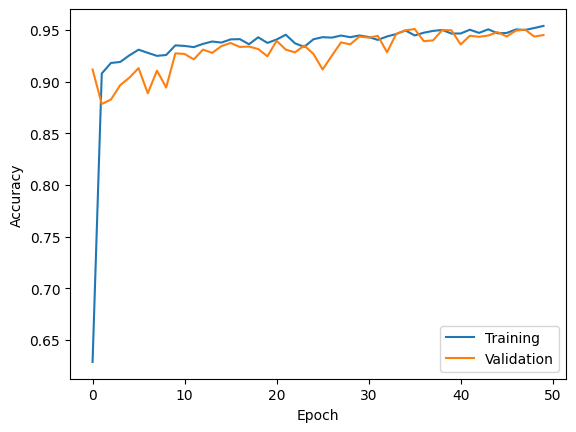

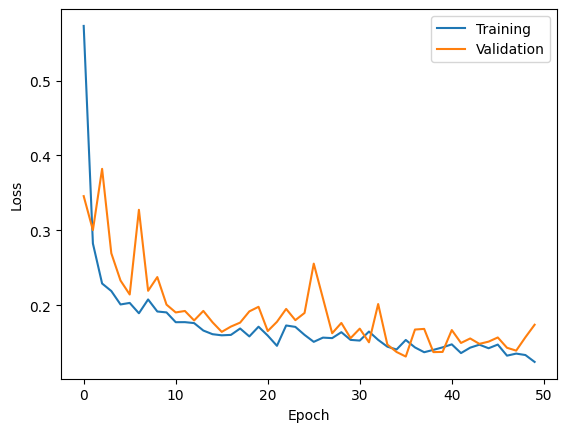

In [29]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_history['accuracy'])
plt.plot(attention_unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

## Loss
plt.plot(attention_unet_history['loss'])
plt.plot(attention_unet_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

In [30]:
# Scores of each model
am_unet_score = (score_eval(attention_unet, validation_images, validation_masks))

1/1 [==============================] - 0s 106ms/step


In [31]:
# Precision and recall of each model
am_unet_precision = (precision_eval(attention_unet, validation_images, validation_masks))
am_unet_recall = (recall_eval(attention_unet, validation_images, validation_masks))

1/1 [==============================] - 0s 117ms/step


In [32]:
# F1-scores of each model
am_unet_f1_score = (f1_score_eval_basic(am_unet_precision, am_unet_recall))

In [33]:
# Print score eval results for each model
print('Attention U-Net accuracy: ', np.mean(am_unet_score), np.std(am_unet_score))

Attention U-Net accuracy:  0.9554729461669922 0.03750597863180415


In [34]:
# Print precision eval results for each model
print('Attention U-Net precision: ', np.mean(am_unet_precision), np.std(am_unet_precision))

Attention U-Net precision:  0.9589474338184809 0.03221419569274887


In [35]:
# Print recall eval results for each model
print('Attention U-Net recall: ', np.mean(am_unet_recall), np.std(am_unet_recall))

Attention U-Net recall:  0.9554729461669922 0.03750597863180415


In [36]:
# Print f1-score eval results for each model
print('Attention U-Net F1-score: ', np.mean(am_unet_f1_score))

Attention U-Net F1-score:  0.9572070370633783


### 4-band Amazon Data

In [ ]:
# Load 4-dim models and history stats
attention_unet_4d = load_model('models_self_trained/unet-attention-4d.hdf5')
attention_unet_4d_history = np.load('models_self_trained/unet-attention-4d-history.npy', allow_pickle='TRUE').item()

OSError: No file or directory found at unet-attention-4d.hdf5

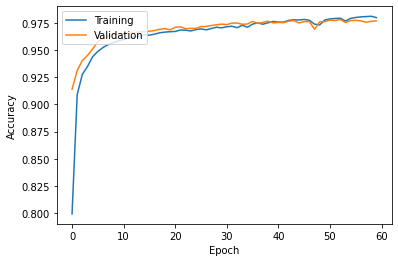

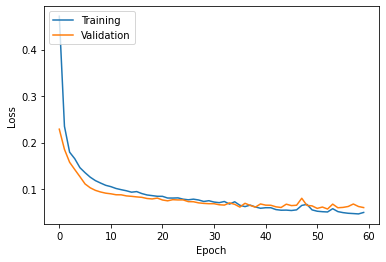

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_history['accuracy'])
plt.plot(attention_unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_history['loss'])
plt.plot(attention_unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Scores of each model
am_unet_4d_score = (score_eval2(attention_unet_4d, validation_images2, validation_masks2))

In [ ]:
# Precision and recall of each model
am_unet_4d_precision = (precision_eval(attention_unet_4d, validation_images2, validation_masks2))
am_unet_4d_recall = (recall_eval(attention_unet_4d, validation_images2, validation_masks2))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# F1-scores of each model
am_unet_4d_f1_score = (f1_score_eval_basic(am_unet_4d_precision, am_unet_4d_recall))

In [ ]:
# Print score eval results for each model
print('Attention U-Net accuracy: ', np.mean(am_unet_4d_score), np.std(am_unet_4d_score))

U-Net accuracy:  0.975186424255371 0.022908675073541194
Attention U-Net accuracy:  0.9779380798339844 0.02111451450962175


In [ ]:
# Print precision eval results for each model
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision), np.std(am_unet_4d_precision))

U-Net precision:  0.976647021383597 0.01991932006610463
Attention U-Net precision:  0.9790256930312505 0.019160716971491704


In [ ]:
# Print recall eval results for each model
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall), np.std(am_unet_4d_recall))

U-Net recall:  0.975186424255371 0.022908675073541194
Attention U-Net recall:  0.9779380798339844 0.02111451450962175


In [ ]:
# Print f1-score eval results for each model
print('Attention U-Net F1-score: ', np.mean(am_unet_4d_f1_score))

U-Net F1-score:  0.9759161763220419
Attention U-Net F1-score:  0.9784815842036025


### Amazon on unseen Atlantic data

In [ ]:
# Score
am_unet_amazon_on_atlantic_score = score_eval2(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)

# Precision
am_unet_amazon_on_atlantic_precision = (precision_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# Recall
am_unet_amazon_on_atlantic_recall = (recall_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# F1-scores of each model
am_unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(am_unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_recall))

In [ ]:
# Print metrics
print('Attention U-Net score: ', np.mean(am_unet_amazon_on_atlantic_score), np.std(am_unet_amazon_on_atlantic_score))

print('Attention U-Net precision: ', np.mean(am_unet_amazon_on_atlantic_precision), np.std(am_unet_amazon_on_atlantic_precision))

print('Attention U-Net recall: ', np.mean(am_unet_amazon_on_atlantic_recall), np.std(am_unet_amazon_on_atlantic_recall))

print('Attention U-Net F1-score: ', am_unet_amazon_on_atlantic_f1_score)

U-Net score:  0.8846941947937011 0.08982562987777168
Attention U-Net score:  0.8828523953755697 0.10684353206781376
U-Net precision:  0.9168732192593768 0.04676348221428434
Attention U-Net precision:  0.9221976372319107 0.04420165970077992
U-Net recall:  0.8846941947937011 0.08982562987777168
Attention U-Net recall:  0.8828523953755697 0.10684353206781375
U-Net F1-score:  0.900496321273587
Attention U-Net F1-score:  0.9020962060135076


### 4-band Atlantic Data

In [ ]:
# Load 4-dim models and history stats
attention_unet_4d_atlantic = load_model('models_self_trained/unet-attention-4d-atlantic.hdf5')
attention_unet_4d_atlantic_history = np.load('models_self_trained/unet-attention-4d-atlantic-history.npy', allow_pickle='TRUE').item()

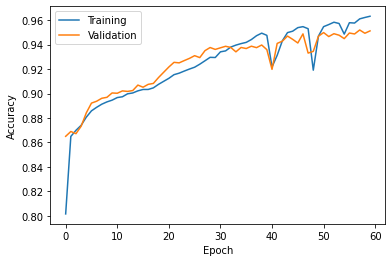

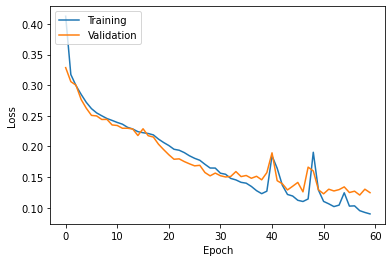

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_atlantic_history['accuracy'])
plt.plot(attention_unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_atlantic_history['loss'])
plt.plot(attention_unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Scores of each model
am_unet_4d_atlantic_score = (score_eval2(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall of each model
am_unet_4d_atlantic_precision = (precision_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

am_unet_4d_atlantic_recall = (recall_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# F1-scores of each model
am_unet_4d_atlantic_f1_score = (f1_score_eval_basic(am_unet_4d_atlantic_precision, am_unet_4d_atlantic_recall))

In [ ]:
# Print metrics
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score), np.std(am_unet_4d_atlantic_score))

print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision), np.std(am_unet_4d_atlantic_precision))

print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall), np.std(am_unet_4d_atlantic_recall))

print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score)

U-Net score:  0.9346261596679688 0.052445221398208
Attention U-Net score:  0.9519517517089844 0.030166279074064023
U-Net precision:  0.9386773001618335 0.03641260419431297
Attention U-Net precision:  0.9563236733896407 0.021722305958663538
U-Net recall:  0.9346261596679688 0.052445221398208
Attention U-Net recall:  0.9519517517089844 0.030166279074064023
U-Net F1-score:  0.9366473494875831
Attention U-Net F1-score:  0.9541327044412243


### Atlantic on unseen Amazon data

In [ ]:
# Score
am_unet_atlantic_on_amazon_score = score_eval2(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)

# Precision
am_unet_atlantic_on_amazon_precision = (precision_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Recall
am_unet_atlantic_on_amazon_recall = (recall_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-scores of each model
am_unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(am_unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_recall))

In [ ]:
# Print metrics
print('Attention U-Net score: ', np.mean(am_unet_atlantic_on_amazon_score), np.std(am_unet_atlantic_on_amazon_score))

print('Attention U-Net precision: ', np.mean(am_unet_atlantic_on_amazon_precision), np.std(am_unet_atlantic_on_amazon_precision))

print('Attention U-Net recall: ', np.mean(am_unet_atlantic_on_amazon_recall), np.std(am_unet_atlantic_on_amazon_recall))

print('Attention U-Net F1-score: ', am_unet_atlantic_on_amazon_f1_score)

U-Net score:  0.8915157000223796 0.0932127976762558
Attention U-Net score:  0.9266117413838705 0.05701273728830019
U-Net precision:  0.9323368415000753 0.046739859260368194
Attention U-Net precision:  0.9445315806544227 0.03958733603853125
U-Net recall:  0.8915157000223796 0.0932127976762558
Attention U-Net recall:  0.9266117413838705 0.05701273728830019
U-Net F1-score:  0.911469445016381
Attention U-Net F1-score:  0.9354858523492012


### Amazon and Atlantic unseen test data

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
am_unet_4d_score_test = (score_eval2(attention_unet_4d, test_images2, test_masks2))

# Precision and recall of each model
am_unet_4d_precision_test = (precision_eval(attention_unet_4d, test_images2, test_masks2))

am_unet_4d_recall_test = (recall_eval(attention_unet_4d, test_images2, test_masks2))

# F1-scores of each model
am_unet_4d_f1_score_test = (f1_score_eval_basic(am_unet_4d_precision_test, am_unet_4d_recall_test))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
am_unet_4d_atlantic_score_test = (score_eval2(attention_unet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
am_unet_4d_atlantic_precision_test = (precision_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

am_unet_4d_atlantic_recall_test = (recall_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
am_unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(am_unet_4d_atlantic_precision_test, am_unet_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('Attention U-Net score: ', np.mean(am_unet_4d_score_test), np.std(am_unet_4d_score_test))

print('Attention U-Net precision: ', np.mean(am_unet_4d_precision_test), np.std(am_unet_4d_precision_test))

print('Attention U-Net recall: ', np.mean(am_unet_4d_recall_test), np.std(am_unet_4d_recall_test))

print('Attention U-Net F1-score: ', am_unet_4d_f1_score_test)

U-Net score:  0.9724159240722656 0.021293534825664956
Attention U-Net score:  0.9747537612915039 0.019844774736773
U-Net precision:  0.9738279305670721 0.018961125689019694
Attention U-Net precision:  0.9758240840110283 0.017958485345777382
U-Net recall:  0.9724159240722656 0.021293534825664956
Attention U-Net recall:  0.9747537612915039 0.019844774736773
U-Net F1-score:  0.9731214151119266
Attention U-Net F1-score:  0.9752886289970736


In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score_test), np.std(am_unet_4d_atlantic_score_test))

print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision_test), np.std(am_unet_4d_atlantic_precision_test))

print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall_test), np.std(am_unet_4d_atlantic_recall_test))

print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score_test)

U-Net score:  0.9373287200927735 0.052345346058224544
Attention U-Net score:  0.9570850372314453 0.01349322683924965
U-Net precision:  0.94243862353405 0.035933966482442785
Attention U-Net precision:  0.9590889631889826 0.0124338547954335
U-Net recall:  0.9373287200927735 0.052345346058224544
Attention U-Net recall:  0.9570850372314453 0.01349322683924965
U-Net F1-score:  0.9398767265089123
Attention U-Net F1-score:  0.9580859523619386


## Produce metric datasets for export

### RGB data

In [ ]:
scores_3d = [am_unet_score]
precision_3d = [am_unet_precision]
recall_3d = [am_unet_recall]
f1_scores_3d = [am_unet_f1_score]

import pandas as pd
metrics_3d = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_3d],
              'precision': [np.mean(n) for n in precision_3d],
              'recall': [np.mean(n) for n in recall_3d],
              'f1_score': [np.mean(n) for n in f1_scores_3d],
              'accuracy_std': [np.std(n) for n in scores_3d],
              'precision_std': [np.std(n) for n in precision_3d],
              'recall_std': [np.std(n) for n in recall_3d]
              }
metrics_3d = pd.DataFrame(metrics_3d)

metrics_3d.to_csv('metrics_self_trained/metrics_3d_amazon.csv', index=False)

# Display results
print("\n=== Attention U-Net Metrics ===")
print(metrics_3d)

### 4-band Amazon data

In [ ]:
# 4D Amazon metrics
scores_4d = [am_unet_4d_score]
precision_4d = [am_unet_4d_precision]
recall_4d = [am_unet_4d_recall]
f1_scores_4d = [am_unet_4d_f1_score]

metrics_4d = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d],
              'precision': [np.mean(n) for n in precision_4d],
              'recall': [np.mean(n) for n in recall_4d],
              'f1_score': [np.mean(n) for n in f1_scores_4d],
              'accuracy_std': [np.std(n) for n in scores_4d],
              'precision_std': [np.std(n) for n in precision_4d],
              'recall_std': [np.std(n) for n in recall_4d]
              }
metrics_4d = pd.DataFrame(metrics_4d)
metrics_4d.to_csv('metrics_self_trained/metrics_4d_amazon.csv', index=False)

### 4-band Atlantic Forest data

In [ ]:
# 4D Atlantic Forest metrics
scores_4d_atl = [am_unet_4d_atlantic_score]
precision_4d_atl = [am_unet_4d_atlantic_precision]
recall_4d_atl = [am_unet_4d_atlantic_recall]
f1_scores_4d_atl = [am_unet_4d_atlantic_f1_score]

metrics_4d_atl = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_atl],
              'precision': [np.mean(n) for n in precision_4d_atl],
              'recall': [np.mean(n) for n in recall_4d_atl],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl],
              'accuracy_std': [np.std(n) for n in scores_4d_atl],
              'precision_std': [np.std(n) for n in precision_4d_atl],
              'recall_std': [np.std(n) for n in recall_4d_atl]
              }
metrics_4d_atl = pd.DataFrame(metrics_4d_atl)
metrics_4d_atl.to_csv('metrics_self_trained/metrics_4d_atlantic_forest.csv', index=False)

### Test set data

In [ ]:
# 4D Amazon Test metrics
scores_4d_test = [am_unet_4d_score_test]
precision_4d_test = [am_unet_4d_precision_test]
recall_4d_test = [am_unet_4d_recall_test]
f1_scores_4d_test = [am_unet_4d_f1_score_test]

metrics_4d_test = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_test],
              'precision': [np.mean(n) for n in precision_4d_test],
              'recall': [np.mean(n) for n in recall_4d_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_test],
              'accuracy_std': [np.std(n) for n in scores_4d_test],
              'precision_std': [np.std(n) for n in precision_4d_test],
              'recall_std': [np.std(n) for n in recall_4d_test]
              }
metrics_4d_test = pd.DataFrame(metrics_4d_test)
metrics_4d_test.to_csv('metrics_self_trained/metrics_4d_amazon_test.csv', index=False)

In [ ]:
# 4D Atlantic Forest Test metrics
scores_4d_atl_test = [am_unet_4d_atlantic_score_test]
precision_4d_atl_test = [am_unet_4d_atlantic_precision_test]
recall_4d_atl_test = [am_unet_4d_atlantic_recall_test]
f1_scores_4d_atl_test = [am_unet_4d_atlantic_f1_score_test]

metrics_4d_atl_test = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_atl_test],
              'precision': [np.mean(n) for n in precision_4d_atl_test],
              'recall': [np.mean(n) for n in recall_4d_atl_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl_test],
              'accuracy_std': [np.std(n) for n in scores_4d_atl_test],
              'precision_std': [np.std(n) for n in precision_4d_atl_test],
              'recall_std': [np.std(n) for n in recall_4d_atl_test]
              }
metrics_4d_atl_test = pd.DataFrame(metrics_4d_atl_test)
metrics_4d_atl_test.to_csv('metrics_self_trained/metrics_4d_atlantic_forest_test.csv', index=False)

### Testing on opposite dataset (e.g. train on Amazon, test on Atlantic)

In [ ]:
# Amazon on Atlantic metrics
scores_amazon_on_atlantic = [am_unet_amazon_on_atlantic_score]
precision_amazon_on_atlantic = [am_unet_amazon_on_atlantic_precision]
recall_amazon_on_atlantic = [am_unet_amazon_on_atlantic_recall]
f1_scores_amazon_on_atlantic = [am_unet_amazon_on_atlantic_f1_score]

metrics_4d_amazon_on_atlantic = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_amazon_on_atlantic],
              'precision': [np.mean(n) for n in precision_amazon_on_atlantic],
              'recall': [np.mean(n) for n in recall_amazon_on_atlantic],
              'f1_score': [np.mean(n) for n in f1_scores_amazon_on_atlantic],
              'accuracy_std': [np.std(n) for n in scores_amazon_on_atlantic],
              'precision_std': [np.std(n) for n in precision_amazon_on_atlantic],
              'recall_std': [np.std(n) for n in recall_amazon_on_atlantic]
              }
metrics_4d_amazon_on_atlantic = pd.DataFrame(metrics_4d_amazon_on_atlantic)
metrics_4d_amazon_on_atlantic.to_csv('metrics_self_trained/metrics_4d_amazon_on_atlantic.csv', index=False)

In [ ]:
# Atlantic on Amazon metrics
scores_atlantic_on_amazon = [am_unet_atlantic_on_amazon_score]
precision_atlantic_on_amazon = [am_unet_atlantic_on_amazon_precision]
recall_atlantic_on_amazon = [am_unet_atlantic_on_amazon_recall]
f1_scores_atlantic_on_amazon = [am_unet_atlantic_on_amazon_f1_score]

metrics_4d_atlantic_on_amazon = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_atlantic_on_amazon],
              'precision': [np.mean(n) for n in precision_atlantic_on_amazon],
              'recall': [np.mean(n) for n in recall_atlantic_on_amazon],
              'f1_score': [np.mean(n) for n in f1_scores_atlantic_on_amazon],
              'accuracy_std': [np.std(n) for n in scores_atlantic_on_amazon],
              'precision_std': [np.std(n) for n in precision_atlantic_on_amazon],
              'recall_std': [np.std(n) for n in recall_atlantic_on_amazon]
              }
metrics_4d_atlantic_on_amazon = pd.DataFrame(metrics_4d_atlantic_on_amazon)
metrics_4d_atlantic_on_amazon.to_csv('metrics_self_trained/metrics_4d_atlantic_on_amazon.csv', index=False)